In [1]:
from clawpack import pyclaw
import numpy  as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML
from __future__ import absolute_import
from clawpack import riemann
#from clawpack.riemann.shallow_roe_with_efix_1D_constants import depth, momentum, num_eqn

In [2]:
def sigmoid(x):
    p = np.multiply(-1,x)
    vals = 1/(1+np.power(np.e,p))
    return vals
#sigmoid([0,1,2])

In [3]:
def entropycalc(hei,velo,num_ghost,t):
    #pass in h-b to adjust for topography
    #ghost = h[:num_ghost] + h[-num_ghost:]
    #ughost = u[:num_ghost] + u[-num_ghost:]#remove BC values
    #print(h)
    hfixed = hei[num_ghost:-num_ghost]
    #newval = np.subtract(hfixed,1)
    #print(hfixed)
    ufixed = velo[num_ghost:-num_ghost] # Removing the ghost cells
    PE = np.multiply(np.multiply(hfixed,np.multiply(ufixed,ufixed) ),0.5)
    KE = np.multiply(hfixed,hfixed)
    currentEntropyArray = np.add(KE, PE) #- hghost - ughost
    summedE = np.sum(currentEntropyArray)/len(hfixed)
    global entropies
    global fullE
    global hss
    global uss
    global dts
    edgeH = [hfixed[0],hfixed[-1]]
    edgeU = [ufixed[0],ufixed[-1]]
    hss.append(np.multiply(edgeH,1))
    uss.append(np.multiply(edgeU,1))
    fullE = fullE + [currentEntropyArray]
    entropies = entropies + [summedE]
    dts = dts + [t]
    del hfixed
    del hei
    del ufixed
    del velo
    #look at two different states and subtract for flux?    
    #fornberg algorithm for finite differences method take coeffs from result. might be in matlab

In [4]:
 def custom_bc(state,dim,t,qbc,num_ghost):
    #print(qbc[0,:].shape)

    #print("que bee c: ", qbc[0,:])
    entropycalc(qbc[0,:],qbc[1,:],num_ghost,t)
    qbc[0,0] = in_height
    qbc[0,1] = in_height
    qbc[0,-1] = in_height-1
    qbc[0,-2] = in_height-1
    
    #qbc[0,:num_ghost] = qbc[]

    qbc[1,0] = in_velocity
    qbc[1,1] = in_velocity
    qbc[1,-1] = qbc[1,-3]
    qbc[1,-2] = qbc[1,-3]
    

In [5]:
def runclaw(in_height,in_velocity,xlower,xupper,num_points,tfinal,slope,num_out):
    claw = pyclaw.Controller()
    claw.tfinal = tfinal
    claw.keep_copy = True
    claw.output_format = None
    claw.num_output_times = num_out
    #rs = riemann.shallow_roe_with_efix_1D
    rs = riemann.shallow_1D_py.shallow_fwave_1d

    num_eqn = 2
    solver = pyclaw.ClawSolver1D(rs)
    solver.order = 2
    solver.num_ghost = 2
    solver.num_waves=2
    solver.num_eqn=2
    #solver.limiters = pyclaw.limiters.tvd.minmod
    #solver.limiters = pyclaw.limiters.tvd.vanleer

    solver.kernel_language = 'Python'

    #solver.all_bcs = pyclaw.BC.periodic
    solver.bc_upper[0] = pyclaw.BC.extrap
    solver.bc_lower[0] = pyclaw.BC.custom
    #solver.bc_upper[0] = pyclaw.BC.custom
    solver.user_bc_lower = custom_bc
    #solver.user_bc_upper = custom_bc
    #print(solver.bc_lower)
    solver.aux_bc_lower[0] = pyclaw.BC.extrap
    solver.aux_bc_upper[0] = pyclaw.BC.extrap


    #solver.all_bcs = pyclaw.BC.periodic

    #xlower = -2.0
    #xupper = 50.0
    mx = num_points
    x = pyclaw.Dimension(xlower,xupper,mx,name='x')
    domain = pyclaw.Domain(x)
    state = pyclaw.State(domain,num_eqn,1)

    state.problem_data['grav'] = 1.0
    state.problem_data['sea_level'] = 0.0
    state.problem_data['dry_tolerance'] = 0.1

    xc = state.grid.x.centers
    x0=0.0


    #state.q[0,:] = hl * (xc <= x0) + hr * (xc > x0) #+ hc*(x0-obj_size < xc)*(xc < x0+obj_size )
    #state.q[0,:] = 3
    state.q[0,:] = in_height# - ((in_height/1.5)*(xc>=x0+10))  #+(1 * (xc<x0)+ (1 - xc/1) * (xc>= x0) * (xc < 1) )
    #state.q[0,:] =  in_height + (0.5 * (xc<x0)+ (0.5 - xc/10) * (xc>= x0) * (xc < 5)) -0.5
    state.q[1,:] = in_velocity #+ 0.5*(xc>= x0) - 0.25*(xc>= x0+15)   #ul * (xc <= x0) + ur * (xc > x0)

    #state.aux[0, :] = 1.0 * np.exp(-xc**2 / 0.2**2) - 1.0
    #state.aux[0,:] = sigmoid(np.multiply(-1,xc))/4
    #else:
    state.aux[0, :] = 0.5 * (xc<x0)+ (0.5 - xc*slope) * (xc>= x0) * (xc < 1/slope *0.5) #low slope IC
    #state.aux[0, :] = 1 * (xc<x0)+ (1 - xc/10) * (xc>= x0) * (xc < 10) #higher slope IC
    #state.aux[0,:] = 0.5* (xc<x0)  #step IC

    #state.aux[0,:] = 0

    #state.q[0,:] = hl * (xc <= x0 - obj_size) + hr * (xc > x0+obj_size) + hc*(x0-obj_size < xc)*(xc < x0+obj_size )
    #state.q[1,:] = hl*ul * (xc <= x0) + hr*ur * (xc > x0)

    #plt.plot(xc,state.q[0,:])
    #plt.plot(xc,state.aux[0,:])
    #plt.plot(xc,state.q[1,:])

    claw.solution = pyclaw.Solution(state,domain)
    claw.solver = solver
    claw.run()
    return [claw.frames,xc]

In [6]:
#plt.plot(xc,state.q[0,:])
#plt.plot(xc,state.aux[0,:])
#plt.plot(xc,state.q[1,:])

In [7]:
def shockcalc(entropy,u,h,dts,ih,iu):
    # need to add upper bc info to calc
    eFluxIn = [0]*(len(h)-1)
    eFluxOut = [0]*(len(h)-1)
    #c = 1 #constant to relate mass to height of water #can factor out since it's in all terms
    #entropies[-5:-1]
    #c(1/2 dh/dt u^2 + h u du/dt + 2gh dh/dt)
    integratedE = 0.0
    adjE = entropy
    for ii in range(1,len(hss)):
        #print(ii)
        dhdt = (-h[ii-1][0] + h[ii][0])/(-dts[ii-1]+dts[ii])
        dudt = (-u[ii-1][0] + u[ii][0])/(-dts[ii-1]+dts[ii])

        eFluxIn[ii-1] =  (0.5*dhdt*(u[ii][0])**2 + h[ii][0]*u[ii][0]*dudt + 2*h[ii][0]*dhdt)
        eFluxOut[ii-1] = (0.5*dhdt*(u[ii][-1])**2 + h[ii][-1]*u[ii][-1]*dudt + 2*h[ii][-1]*dhdt)
        if dts[ii-1]==dts[ii]:
            eFluxIn[ii-1] = 0.0
            eFluxOut[ii-1] = 0.0
        efi = np.sum(eFluxIn)
        efo = np.sum(eFluxOut)
        #print(efi+efo, " efi and efo")
        adjE[ii-1] = np.add(adjE[ii-1],(efi+efo) )
        #print(efi, " EFLUX IN")
        #print(efo, " EFLUX OUT")
    for ii in range(1,len(h)-1):
        #integratedE = integratedE + entropies[ii] -(ih-h[ii][0])*(iu-u[ii][0])**2 -(ih-h[ii][0])**2  - entropies[0]
        #integratedE = integratedE + entropies[ii] - eFluxIn[ii] + eFluxOut[ii] -entropies[0]
        integratedE = integratedE + adjE[ii] -entropy[0]
    return integratedE

In [8]:

in_heights = [0.7,0.8,0.9,1.1,1.3,1.5,1.7,1.9,2.3,3.0]
slopes = [1/16,1/8,1/4,1/3,1/2,3/4,1,1.5,2,2.5,3,4,5]
velocities = [0.25,0.5,0.75,0.85,1.0,1.1,1.25,1.5,1.75]
#in_heights = [.7,1.1]
#slopes = [1/16,1/2]
#velocities = [.25,1.0]
for kk in range(len(velocities)):
    allEs = []
    print(kk, " kk out of 7")
    for ii in range(len(in_heights)):
        print(ii, " ii out of 10")
        tempE = []
        for jj in range(len(slopes)):

            in_height = in_heights[ii]
            slope = slopes[jj]
            in_velocity = velocities[kk]
            xlower = -5
            xupper = 30
            num_points=1000
            entropies = []
            fullE = []
            hss = []
            uss = []
            dts = []
            tfinal = 75
            solns,xc = runclaw(in_height, in_velocity, xlower, xupper,num_points,tfinal,slope,1)
            tempE.append(shockcalc(entropies,uss,hss,dts,in_height,in_velocity))
        
        allEs = allEs + [tempE]
    print(allEs)
    
    for rr in range(len(allEs)):
        #plt.figure(rr)
        #plt.subplot(111)
        plt.title(str("initial height: "+ str(in_heights[rr])+ " and velocity" + str(velocities[kk]) ))
        plt.xlabel("slope")
        plt.ylabel("entropy")
        plt.plot(slopes,allEs[rr])
        plt.savefig(str(velocities[kk])+'output'+str(rr)+'.png', dpi=400)
        plt.clf()

0  kk out of 7
0  ii out of 10
2019-03-28 15:54:32,058 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 15:54:32,063 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 15:54:38,472 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 15:54:41,988 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                

/home/max/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/home/max/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


2019-03-28 15:54:48,542 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 15:54:52,246 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 15:54:52,248 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 15:54:58,854 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 15:55:02,657 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0. 

2019-03-28 15:56:58,057 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 15:57:04,570 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 15:57:08,335 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 15:57:08,338 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 15:57:14,944 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 15:57:18,844 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 15:59:29,269 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 15:59:35,714 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 15:59:39,380 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 15:59:39,383 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 15:59:45,926 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 15:59:49,727 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 16:01:43,335 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:01:49,504 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 16:01:52,898 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 16:01:52,904 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:01:59,145 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 16:02:02,631 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 16:03:47,992 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:03:53,503 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 16:03:56,295 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 16:03:56,298 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:04:01,790 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 16:04:04,582 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 16:05:37,092 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:05:42,788 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 16:05:45,770 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 16:05:45,776 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:05:51,476 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 16:05:54,467 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 16:07:30,487 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:07:36,394 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 16:07:39,582 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 16:07:39,585 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:07:45,470 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 16:07:48,665 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 16:09:29,088 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:09:35,194 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 16:09:38,582 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 16:09:38,585 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:09:44,684 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 16:09:48,076 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 16:11:33,328 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:11:39,806 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 16:11:43,616 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 16:11:43,623 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:11:50,097 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 16:11:53,908 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 16:13:48,575 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:13:55,700 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 16:14:00,245 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 16:14:00,247 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:14:07,377 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 16:14:11,934 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

1  kk out of 7
0  ii out of 10
2019-03-28 16:16:13,346 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 16:16:13,349 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:16:20,725 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 16:16:25,375 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                

2019-03-28 16:18:49,064 INFO CLAW: Solution 1 computed for time t=75.000000
1  ii out of 10
2019-03-28 16:18:53,947 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 16:18:53,950 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:19:01,353 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 16:19:05,997 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported i

2019-03-28 16:21:23,771 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:21:31,430 INFO CLAW: Solution 1 computed for time t=75.000000
2  ii out of 10
2019-03-28 16:21:36,366 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 16:21:36,368 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:21:43,803 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 16:21:48,475 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previou

2019-03-28 16:24:08,517 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:24:16,301 INFO CLAW: Solution 1 computed for time t=75.000000
3  ii out of 10
2019-03-28 16:24:21,361 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 16:24:21,366 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:24:28,870 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 16:24:33,521 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previou

2019-03-28 16:26:57,969 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:27:05,956 INFO CLAW: Solution 1 computed for time t=75.000000
4  ii out of 10
2019-03-28 16:27:11,276 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 16:27:11,279 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:27:18,505 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 16:27:22,924 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previou

2019-03-28 16:29:38,824 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:29:46,392 INFO CLAW: Solution 1 computed for time t=75.000000
5  ii out of 10
2019-03-28 16:29:51,346 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 16:29:51,349 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:29:57,777 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 16:30:01,455 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previou

2019-03-28 16:31:53,612 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:32:00,039 INFO CLAW: Solution 1 computed for time t=75.000000
6  ii out of 10
2019-03-28 16:32:03,734 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 16:32:03,737 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:32:10,202 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 16:32:13,880 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previou

2019-03-28 16:34:05,211 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:34:11,648 INFO CLAW: Solution 1 computed for time t=75.000000
7  ii out of 10
2019-03-28 16:34:15,329 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 16:34:15,331 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:34:21,933 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 16:34:25,795 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previou

2019-03-28 16:36:20,699 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:36:27,340 INFO CLAW: Solution 1 computed for time t=75.000000
8  ii out of 10
2019-03-28 16:36:31,206 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 16:36:31,214 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:36:38,064 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 16:36:42,263 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previou

2019-03-28 16:38:48,349 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:38:55,583 INFO CLAW: Solution 1 computed for time t=75.000000
9  ii out of 10
2019-03-28 16:38:59,804 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 16:38:59,807 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:39:07,502 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 16:39:12,497 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previou

2019-03-28 16:41:28,824 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:41:36,259 INFO CLAW: Solution 1 computed for time t=75.000000
[[-9445.1896252158149, -9525.4081755622683, -9573.5870616024167, -9593.6430322820761, -9608.8249588064027, -9621.9289745312362, -9630.9354037995163, -9644.0841717333678, -9648.2783620368336, -9666.1012170458434, -9654.4566355468232, -9655.7519154746496, -9685.059307411344], [-70142.664583793317, -71925.653897996817, -72212.024970131679, -72277.457350172233, -72308.200128553479, -72353.359412120393, -72363.382939993811, -72427.350758908098, -72484.465341368879, -72517.946784871834, -72561.362811521365, -72728.903459230773, -72833.655406162783], [-141501.45900125513, -151154.69079731766, -152402.70807886845, -152619.0091278489, -152800.51233037186, -152960.4704234332, -153004.38901578728, -153103.41083585058, -153194.97672441936, -153323.26147920408, -153418.12350769425, -153756.83625828798, -154016.48967342643], [-294494.79110058479, -334

2019-03-28 16:43:38,953 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:43:47,269 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 16:43:53,208 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 16:43:53,211 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:44:01,563 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 16:44:07,517 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 16:46:42,578 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:46:50,851 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 16:46:56,707 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 16:46:56,716 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:47:04,978 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 16:47:10,866 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 16:49:47,721 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:49:56,173 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 16:50:02,033 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 16:50:02,036 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:50:10,494 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 16:50:16,379 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 16:52:55,169 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:53:03,761 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 16:53:09,774 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 16:53:09,777 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:53:18,371 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 16:53:24,383 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 16:56:06,463 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:56:15,239 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 16:56:21,478 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 16:56:21,480 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:56:30,319 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 16:56:36,573 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 16:59:16,476 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:59:24,906 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 16:59:30,877 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 16:59:30,880 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 16:59:39,291 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 16:59:45,225 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 17:02:12,769 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 17:02:20,469 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 17:02:25,574 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 17:02:25,577 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 17:02:33,334 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 17:02:38,495 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 17:04:47,863 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 17:04:54,903 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 17:04:59,252 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 17:04:59,255 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 17:05:06,293 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 17:05:10,644 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 17:07:20,373 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 17:07:27,668 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 17:07:32,312 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 17:07:32,315 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 17:07:39,604 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 17:07:44,251 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 17:10:04,507 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 17:10:12,314 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 17:10:17,560 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 17:10:17,563 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 17:10:25,406 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 17:10:30,681 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 17:12:14,720 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 17:12:23,473 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 17:12:29,979 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 17:12:29,982 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 17:12:38,591 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 17:12:45,078 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 17:15:30,487 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 17:15:39,095 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 17:15:45,355 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 17:15:45,358 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 17:15:53,972 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 17:16:00,240 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 17:18:46,167 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 17:18:54,815 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 17:19:01,019 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 17:19:01,022 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 17:19:09,602 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 17:19:15,845 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 17:22:14,621 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 17:22:24,463 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 17:22:30,970 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 17:22:30,972 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 17:22:40,705 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 17:22:47,241 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 17:25:45,104 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 17:25:54,782 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 17:26:01,506 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 17:26:01,515 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 17:26:11,114 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 17:26:17,872 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 17:29:17,414 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 17:29:27,064 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 17:29:33,885 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 17:29:33,888 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 17:29:43,592 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 17:29:50,440 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 17:33:13,193 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 17:33:22,225 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 17:33:28,424 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 17:33:28,427 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 17:33:37,515 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 17:33:43,857 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 17:36:23,298 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 17:36:31,339 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 17:36:36,162 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 17:36:36,165 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 17:36:44,069 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 17:36:48,901 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 17:39:11,080 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 17:39:19,191 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 17:39:24,223 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 17:39:24,226 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 17:39:32,334 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 17:39:37,371 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 17:42:06,098 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 17:42:14,715 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 17:42:20,353 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 17:42:20,356 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 17:42:28,998 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 17:42:34,644 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 17:44:18,241 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 17:44:28,284 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 17:44:35,835 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 17:44:35,838 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 17:44:45,402 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 17:44:52,789 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 17:48:03,469 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 17:48:13,704 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 17:48:20,748 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 17:48:20,751 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 17:48:31,469 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 17:48:38,676 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 17:51:38,938 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 17:51:48,426 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 17:51:55,327 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 17:51:55,330 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 17:52:04,921 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 17:52:12,927 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 17:55:12,803 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 17:55:22,574 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 17:55:29,402 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 17:55:29,405 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 17:55:39,584 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 17:55:46,580 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 17:58:52,936 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 17:59:01,954 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 17:59:08,445 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 17:59:08,448 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 17:59:17,573 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 17:59:24,293 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 18:02:22,035 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 18:02:31,059 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 18:02:37,545 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 18:02:37,548 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 18:02:46,823 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 18:02:53,611 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 18:05:59,854 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 18:06:09,455 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 18:06:15,922 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 18:06:15,925 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 18:06:25,646 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 18:06:32,534 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 18:09:39,120 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 18:09:48,507 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 18:09:54,554 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 18:09:54,557 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 18:10:03,825 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 18:10:10,111 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 18:13:03,209 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 18:13:11,422 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 18:13:16,686 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 18:13:16,690 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 18:13:24,930 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 18:13:30,239 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 18:15:58,875 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 18:16:07,503 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 18:16:13,293 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 18:16:13,296 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 18:16:21,901 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 18:16:27,706 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

5  kk out of 7
0  ii out of 10
2019-03-28 18:19:13,804 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 18:19:13,807 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 18:19:24,946 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 18:19:33,405 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                

2019-03-28 18:23:15,932 INFO CLAW: Solution 1 computed for time t=75.000000
1  ii out of 10
2019-03-28 18:23:24,483 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 18:23:24,486 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 18:23:34,804 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 18:23:42,624 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported i

2019-03-28 18:27:03,435 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 18:27:13,733 INFO CLAW: Solution 1 computed for time t=75.000000
2  ii out of 10
2019-03-28 18:27:21,731 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 18:27:21,735 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 18:27:31,868 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 18:27:39,277 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previou

2019-03-28 18:30:55,144 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 18:31:05,396 INFO CLAW: Solution 1 computed for time t=75.000000
3  ii out of 10
2019-03-28 18:31:12,961 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 18:31:12,964 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 18:31:23,028 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 18:31:30,187 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previou

2019-03-28 18:34:44,278 INFO CLAW: Solution 0 computed for time t=0.000000


/home/max/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in multiply
  # Remove the CWD from sys.path while we load stuff.
/home/max/anaconda3/lib/python3.6/site-packages/clawpack/pyclaw/limiters/tvd.py:108: RuntimeWarning: overflow encountered in square
  wave_norm2 = np.sum(np.square(wave),axis=0)


2019-03-28 18:34:56,284 INFO CLAW: Solution 1 computed for time t=75.000000


/home/max/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in multiply
  # This is added back by InteractiveShellApp.init_path()
/home/max/anaconda3/lib/python3.6/site-packages/clawpack/riemann/shallow_1D_py.py:209: RuntimeWarning: overflow encountered in square
  phi_l = q_l[0,:] * u_l**2 + 0.5 * g * q_l[0,:]**2
/home/max/anaconda3/lib/python3.6/site-packages/clawpack/riemann/shallow_1D_py.py:210: RuntimeWarning: overflow encountered in square
  phi_r = q_r[0,:] * u_r**2 + 0.5 * g * q_r[0,:]**2
/home/max/anaconda3/lib/python3.6/site-packages/clawpack/riemann/shallow_1D_py.py:217: RuntimeWarning: invalid value encountered in subtract
  delta2 = phi_r - phi_l + g * 0.5 * (q_r[0,:] + q_l[0,:]) * (aux_r[0,:] - aux_l[0,:])
/home/max/anaconda3/lib/python3.6/site-packages/clawpack/riemann/shallow_1D_py.py:229: RuntimeWarning: invalid value encountered in multiply
  amdq[m,:] += (s[mw,:] < 0.0) * fwave[m,mw,:]
/home/max/anaconda3/lib/python3

4  ii out of 10
2019-03-28 18:35:06,166 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 18:35:06,169 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 18:35:16,184 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 18:35:23,255 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://

2019-03-28 18:38:51,668 INFO CLAW: Solution 1 computed for time t=75.000000
5  ii out of 10
2019-03-28 18:38:59,263 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 18:38:59,267 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 18:39:09,475 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 18:39:16,643 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported i

2019-03-28 18:42:33,548 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 18:42:44,371 INFO CLAW: Solution 1 computed for time t=75.000000
6  ii out of 10
2019-03-28 18:42:52,197 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 18:42:52,200 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 18:43:02,331 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 18:43:09,349 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previou

2019-03-28 18:46:39,445 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 18:46:50,291 INFO CLAW: Solution 1 computed for time t=75.000000
7  ii out of 10
2019-03-28 18:46:58,459 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 18:46:58,461 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 18:47:08,268 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 18:47:14,958 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previou

2019-03-28 18:50:26,174 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 18:50:35,926 INFO CLAW: Solution 1 computed for time t=75.000000
8  ii out of 10
2019-03-28 18:50:42,759 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 18:50:42,762 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 18:50:51,463 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 18:50:56,999 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previou

2019-03-28 18:53:35,079 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 18:53:43,747 INFO CLAW: Solution 1 computed for time t=75.000000
9  ii out of 10
2019-03-28 18:53:49,278 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 18:53:49,280 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 18:53:58,300 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 18:54:04,324 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previou

2019-03-28 18:56:47,128 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 18:56:55,394 INFO CLAW: Solution 1 computed for time t=75.000000
[[-784.37411820218472, -797.36162252724466, -802.86718675214479, -804.09663012291094, -805.53844146832284, -806.45136228800015, -806.80260900926294, -807.38201214169544, -807.60627762229535, -807.76584885967009, -808.11653078781535, -808.37084358227389, -808.62798482116807], [-1094.9492847882582, -1093.9055731191092, -1091.3181552055514, -1090.8918932474198, -1090.1365731500564, -1089.541801775244, -1089.4066082206505, -1089.31026101618, -1089.1924840206539, -1089.4945661158301, -1089.561911712234, -1090.1424843256007, -1090.5341962171876], [-1419.6464851737708, -1383.4308061254494, -1362.7141872442155, -1357.2480995286596, -1351.7296143575763, -1348.0925805986974, -1346.2843808484715, -1345.0372368212038, -1344.1352926090208, -1344.1583101958427, -1344.525385531347, -1345.1995015244156, -1346.3134068398056], [-1814.4045968802284, -1600.

2019-03-28 18:59:50,484 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 19:00:04,140 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 19:00:14,049 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 19:00:14,052 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 19:00:26,061 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 19:00:35,991 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 19:04:23,804 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 19:04:35,060 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 19:04:43,986 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 19:04:43,989 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 19:04:55,084 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 19:05:03,972 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 19:08:35,234 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 19:08:45,542 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 19:08:54,253 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 19:08:54,256 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 19:09:05,081 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 19:09:13,655 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 19:12:34,010 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 19:12:43,557 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 19:12:51,120 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 19:12:51,123 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 19:13:00,655 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 19:13:08,214 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 19:16:17,948 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 19:16:27,813 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 19:16:35,423 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 19:16:35,426 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 19:16:45,325 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 19:16:52,908 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 19:20:05,180 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 19:20:15,093 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 19:20:22,809 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 19:20:22,812 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 19:20:32,797 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 19:20:40,525 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 19:23:56,868 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 19:24:07,000 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 19:24:14,948 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 19:24:14,951 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 19:24:25,099 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 19:24:33,056 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 19:27:46,389 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 19:27:56,277 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 19:28:04,089 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 19:28:04,091 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 19:28:14,030 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 19:28:21,893 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 19:31:05,384 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 19:31:13,671 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 19:31:19,325 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 19:31:19,328 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 19:31:27,575 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 19:31:33,214 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 19:34:11,356 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 19:34:19,858 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 19:34:25,879 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 19:34:25,882 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 19:34:34,372 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 19:34:40,400 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 19:37:01,563 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 19:37:13,667 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 19:37:24,958 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 19:37:24,960 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 19:37:37,053 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 19:37:48,361 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 19:41:57,977 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 19:42:09,305 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 19:42:19,410 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 19:42:19,413 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 19:42:30,730 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 19:42:40,874 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 19:46:30,654 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 19:46:41,518 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 19:46:50,836 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 19:46:50,839 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 19:47:01,643 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 19:47:10,978 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 19:50:46,318 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 19:50:56,585 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 19:51:05,080 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 19:51:05,083 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 19:51:15,251 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 19:51:23,766 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 19:54:48,388 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 19:54:58,483 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 19:55:06,769 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 19:55:06,771 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 19:55:16,837 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 19:55:25,127 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 19:58:48,497 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 19:58:58,931 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 19:59:07,253 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 19:59:07,256 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 19:59:17,689 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 19:59:26,031 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 20:02:52,340 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 20:03:02,829 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 20:03:11,292 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 20:03:11,295 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 20:03:21,791 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 20:03:30,277 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 20:06:58,882 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 20:07:09,555 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 20:07:18,160 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 20:07:18,163 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 20:07:28,799 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 20:07:37,439 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 20:11:00,059 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 20:11:09,680 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 20:11:17,133 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 20:11:17,136 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 20:11:26,695 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 20:11:34,119 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 20:14:33,162 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 20:14:41,977 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 20:14:48,390 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 20:14:48,392 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 20:14:57,220 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 20:15:03,635 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 20:16:54,374 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 20:17:07,892 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 20:17:21,580 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 20:17:21,583 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 20:17:35,137 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 20:17:48,907 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 20:22:49,445 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 20:23:01,969 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 20:23:13,962 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 20:23:13,965 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 20:23:26,487 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 20:23:38,508 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 20:28:08,779 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 20:28:20,563 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 20:28:31,382 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 20:28:31,385 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 20:28:43,214 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 20:28:54,090 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 20:33:03,611 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 20:33:14,541 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 20:33:24,058 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 20:33:24,060 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 20:33:34,934 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 20:33:44,486 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 20:37:29,221 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 20:37:39,791 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 20:37:48,721 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 20:37:48,724 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 20:37:59,341 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 20:38:08,360 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 20:41:44,027 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 20:41:54,497 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 20:42:03,262 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 20:42:03,265 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 20:42:13,843 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 20:42:22,710 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 20:45:58,834 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 20:46:09,496 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 20:46:18,189 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 20:46:18,192 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 20:46:28,934 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 20:46:37,825 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 20:50:17,128 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 20:50:27,793 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 20:50:36,486 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 20:50:36,489 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 20:50:47,322 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 20:50:56,273 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 20:54:38,671 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 20:54:50,342 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 20:54:58,664 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 20:54:58,666 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 20:55:09,207 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 20:55:17,854 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

2019-03-28 20:58:57,663 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 20:59:07,281 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 20:59:14,305 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 20:59:14,308 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 20:59:23,812 INFO CLAW: Solution 1 computed for time t=75.000000
2019-03-28 20:59:30,806 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will

[-760.80696280489531, -791.0881345622297, -803.27610858169498, -805.82381752504205, -811.45940555006177, -816.39564968232833, -820.40866130552479, -824.12365906012553, -824.80595475388293, -825.19790063494031, -825.49907121031276, -825.86246417563461, -826.09976107423472]


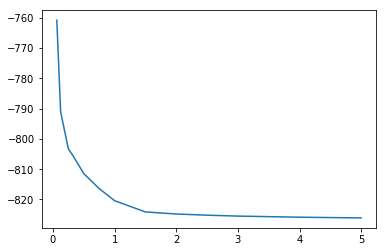

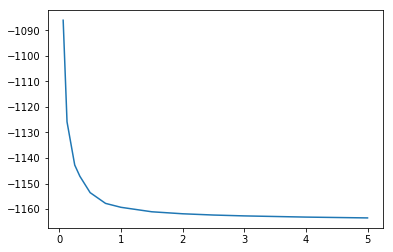

In [9]:
print(allEs[0])
plt.figure(1)
plt.subplot(111)
plt.plot(slopes,allEs[0])
plt.figure(2)
plt.subplot(111)
plt.plot(slopes,allEs[1])

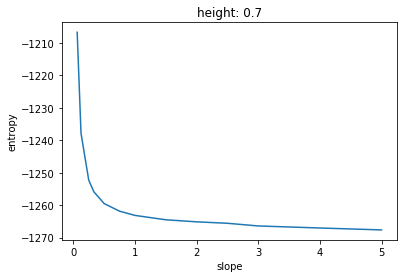

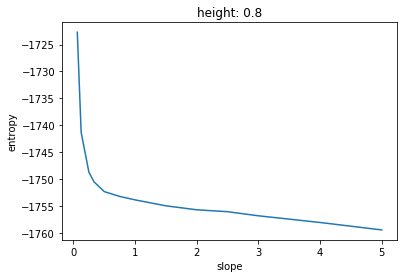

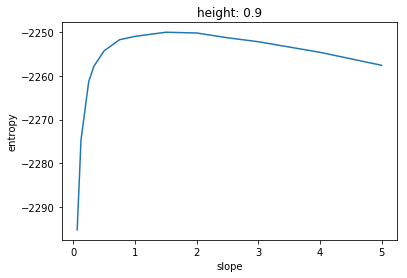

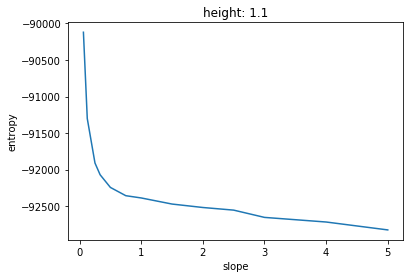

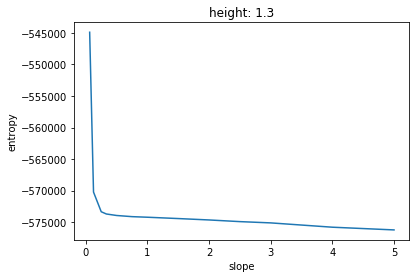

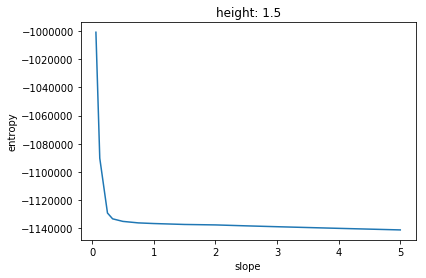

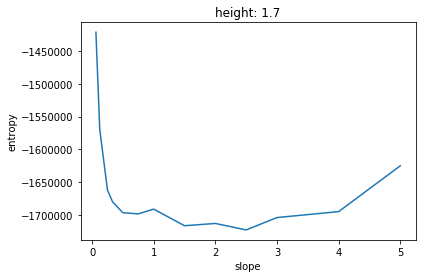

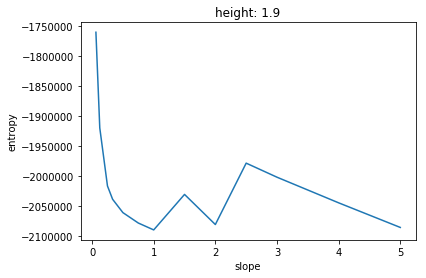

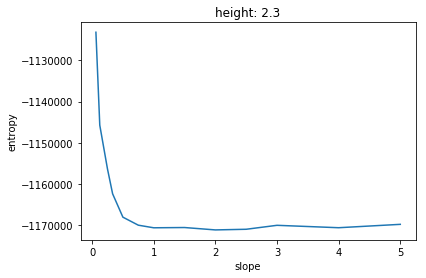

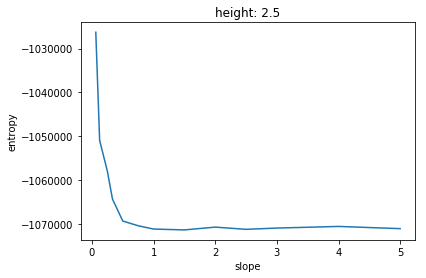

In [17]:
for ii in range(len(allEs)):
    plt.figure(ii)
    plt.subplot(111)
    plt.title(str("initial height: "+ str(in_heights[ii])+ " and velocity" + str(velocities[ii]) ))
    plt.xlabel("slope")
    plt.ylabel("entropy")
    plt.plot(slopes,allEs[ii])
    plt.savefig(str(velocity)+'output'+str(ii)+'.png', dpi=400)

2019-03-28 09:41:05,872 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-28 09:41:05,876 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-28 09:41:06,019 INFO CLAW: Solution 1 computed for time t=1.500000
2019-03-28 09:41:06,147 INFO CLAW: Solution 2 computed for time t=3.000000
2019-03-28 09:41:06,277 INFO CLAW: Solution 3 computed for time t=4.500000
2019-03-28 09:41:06,407 INFO CLAW: Solution 4 computed for time t=6.000000
2019-03-28 09:41:06,538 INFO CLAW: Solution 5 computed for time t=7.500000
2019-03-28 09:41:06,670 INFO CLAW: Solution 6 computed for time 

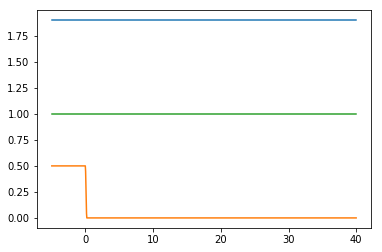

In [10]:
in_height = in_heights[7]
slope = slopes[10]
in_velocity = 1.0
xlower = -5
xupper = 40
num_points=1000
entropies = []
fullE = []
hss = []
uss = []
dts = []
tfinal = 75
solns,xc = runclaw(in_height, in_velocity, xlower, xupper,num_points,tfinal,slope,50)

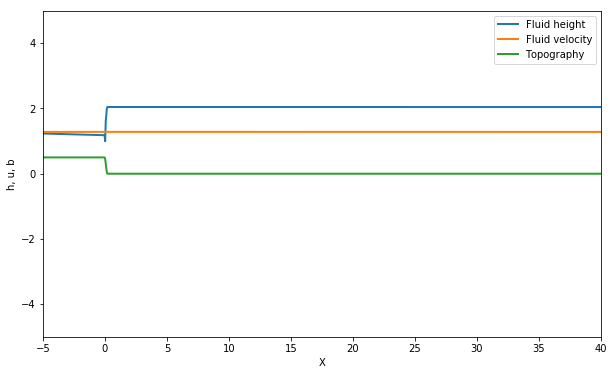

In [11]:
fig = plt.figure(figsize=(10,6))
ax = plt.axes()

frame = solns[0]
depth = frame.q[0,:]
line1, = ax.plot([], [], lw=2)
line2, = ax.plot([], [], lw=2)
line3, = ax.plot([], [], lw=2)
plt.legend(['Fluid height','Fluid velocity', 'Topography'])
plt.xlabel('X')
plt.ylabel('h, u, b')
ax.set_xlim(xlower,xupper)
ax.set_ylim(-5,5)
frame_number = -1
frame = solns[frame_number]
depth = frame.q[0,:]
velocity = frame.q[1,:]
b = frame.aux[0,:]
line1.set_data(xc,depth)
line2.set_data(xc,velocity)
line3.set_data(xc,b)

In [16]:
#in_height = 1.75
#in_velocity = 2
#solns = runclaw(in_height, in_velocity)
fig = plt.figure(figsize=(10,6))
ax = plt.axes()

frame = solns[0]
depth = frame.q[0,:]
line1, = ax.plot([], [], lw=2)
line2, = ax.plot([], [], lw=2)
line3, = ax.plot([], [], lw=2)
plt.legend(['Fluid height','Fluid velocity', 'Topography'])
plt.xlabel('X')
plt.ylabel('h, u, b')
ax.set_xlim(xlower,xupper)
ax.set_ylim(-5,5)
def fplot(frame_number):
    frame = solns[frame_number]
    depth = frame.q[0,:]
    velocity = frame.q[1,:]
    b = frame.aux[0,:]
    line1.set_data(xc,depth)
    line2.set_data(xc,velocity)
    line3.set_data(xc,b)
    return line1,

anim = animation.FuncAnimation(fig, fplot, frames=len(solns), interval=50, repeat=False) #len(claw.frames) can be put in frames=
plt.close()
HTML(anim.to_jshtml())

In [69]:
#test = solns[15]
#test.q[0,:]

def shockcalc(entropy,u,h,dts,ih,iu):
    eFluxIn = [None]*(len(h)-1)
    eFluxOut = [None]*(len(h)-1)
    #c = 1 #constant to relate mass to height of water #can factor out since it's in all terms
    #entropies[-5:-1]
    #c(1/2 dh/dt u^2 + h u du/dt + 2gh dh/dt)
    integratedE = 0.0
    for ii in range(1,len(hss)):
        #print(ii)
        dhdt = (h[ii-1][0] -h[ii][0])/(dts[ii-1]-dts[ii])
        dudt = (u[ii-1][0] -u[ii][0])/(dts[ii-1]-dts[ii])

        eFluxIn[ii-1] =  (0.5*dhdt*(u[ii][0])**2 + h[ii][0]*u[ii][0]*dudt + 2*h[ii][0]*dhdt)
        eFluxOut[ii-1] = (0.5*dhdt*(u[ii][-1])**2 + h[ii][-1]*u[ii][-1]*dudt + 2*h[ii][-1]*dhdt)

        if dts[ii-1]==dts[ii]:
            eFluxIn[ii-1] = 0.0
            eFluxOut[ii-1] = 0.0
    for ii in range(1,len(h)-1):
        integratedE = integratedE + entropies[ii] - (ih-h[ii][0]) - (iu-u[ii][0]) - entropies[0]
        #integratedE = integratedE + entropies[ii] - eFluxIn[ii] + eFluxOut[ii] -entropies[0]
    return integratedE

In [84]:
h[1][0]
#print(np.max(eFluxOut))
#print(np.max(eFluxIn))
#filter(lambda v: v==v, eFluxOut)
#eFluxOut = eFluxOut[np.logical_not(np.isnan(eFluxOut))]
#eFluxOut = eFluxOut[~np.isnan(eFluxOut)]

1.5

In [85]:
#eFluxIn = [None]*(len(h)-1)
#dhdt = (h[ii-1][0] -h[ii][0])/(dts[0]-dts[1])
#dudt = (u[ii-1][0] -u[ii][0])/(dts[0]-dts[1])
#print(dudt)
#eFluxIn[0] = (0.5*dhdt*(u[ii][0])**2 + h[ii][0]*u[ii][0]*dudt + 2*h[ii][0]*dhdt)

In [86]:
print(integratedE)

-127.832393429


In [82]:
print(entropies[-2] - eFluxIn[-2] - eFluxOut[-2] -entropies[0])

0.0209496783448


In [75]:
np.sum(np.subtract(h,1.5))

-1112.2896952423175

In [76]:
np.sum(np.subtract(u,1))

1158.5384300680125

In [77]:
np.sum(u)

11116.538430068013